### **Importing Libraries**

In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import string
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

[nltk_data] Downloading package punkt to /home/chetan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda


### **Importing and Cleaning Dataset**

In [2]:
with open('./datasets/Auguste_Maquet.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()

print("Dataset Loaded")

corpus = corpus.lower()
clean_text = sent_tokenize(corpus)
translator = str.maketrans('', '', string.punctuation)
clean_text = [sentence.translate(translator) for sentence in clean_text]
# print(len(clean_text))


Dataset Loaded


### **Tokenization and Emmbedding**

In [3]:
tokenized_corpus = [word_tokenize(sentence) for sentence in clean_text]
word_to_ind = {}
longest_seq = 1

for i in range(len(tokenized_corpus)):
    token_arr = tokenized_corpus[i]
    longest_seq = max(longest_seq, len(token_arr))
    
    #Vocabulary
    for tokken in token_arr:
        if tokken not in word_to_ind:
            word_to_ind[tokken] = len(word_to_ind)
    
    token_arr = ['<sos>'] * 5 + token_arr + ['<eos>'] * 5
    tokenized_corpus[i] = token_arr

# print(tokenized_corpus[2])
word_to_ind["<sos>"] = len(word_to_ind)
word_to_ind["<eos>"] = len(word_to_ind)
print(len(word_to_ind))


word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=200, window=5, min_count=1, workers=4)


26161


### **Test-Train Split**

In [4]:
train_val_data, test_data = train_test_split(tokenized_corpus, test_size=0.2)

train_data, validation_data = train_test_split(train_val_data, test_size=0.125)

# Print the sizes of each set
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")


Training data size: 24571
Validation data size: 3511
Test data size: 7021


### **Neural Network Model**

In [5]:
class NeuralLM(nn.Module): #https://cnvrg.io/pytorch-lstm/
    def __init__(self, emb_dim, hidden_size, vocab_size, pretrained_embeddings, num_layers=1,dropout_rate=0.1):
        super(NeuralLM, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings), freeze=True)
        
        # LSTM layer
        self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers=num_layers, batch_first=True,dropout=dropout_rate if num_layers > 1 else 0)
        self.act_fn = nn.ReLU()
        self.dense_layer = nn.Linear(hidden_size, 128) #https://stackoverflow.com/questions/61149523/understanding-the-structure-of-my-lstm-model
        # Output layer
        self.class_layer = nn.Linear(128, vocab_size)
        self.dropout_l = nn.Dropout(dropout_rate)

    def forward(self, inp, hidden=None):
        
        embedded = self.embeddings(inp)
        
        lstm_out, hidden = self.lstm(embedded, hidden)
        lstm_out = self.dropout_l(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)
        # Apply dense layer and activation
        dense_out = self.act_fn(self.dense_layer(self.act_fn(lstm_out)))
        # Final output layer
        logits = self.class_layer(dense_out)
        
        return logits
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_size).zero_())

### **Creating Datasets**

In [6]:
class LM_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return (self.data.size(0) - 1) // self.seq_len

    def __getitem__(self, idx):
        start = idx * self.seq_len
        end = start + self.seq_len
        src = self.data[start:end]
        target = self.data[start+1:end+1]
        return src, target

### **Creating Input**

In [7]:
def prepare_data(sentences, word_to_index, max_len=None):
    def words_to_indices(words, word_to_index):
        return [word_to_index.get(word, 0) for word in words]

    all_indices = []

    for sentence in sentences:
        word_indices = words_to_indices(sentence, word_to_index)
        
        # if max_len is not None:
        #     word_indices = word_indices[:max_len]
        
        all_indices.extend(word_indices)
    
    data = torch.LongTensor(all_indices)
    return data

train_gram_inp = prepare_data(train_data, word_to_ind, max_len=40)
val_gram_inp= prepare_data(validation_data, word_to_ind, max_len=40)
test_gram_inp = prepare_data(test_data, word_to_ind, max_len=40)



### **Train Model**

In [8]:
dataset_train = LM_Dataset(train_gram_inp, 40)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

dataset_val = LM_Dataset(val_gram_inp, 40)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128)

pretrained_embeddings = word2vec_model.wv.vectors

num_epochs = 5
model = NeuralLM(200, 300, len(word_to_ind), pretrained_embeddings, num_layers=1, dropout_rate=0.3)
model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
perp_vis_t = []
perp_vis_val = []
clip = 0.1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

with open('2022101096_LM2_Train_Perplexity.txt', 'w') as train_file, open('2022101096_LM2_Validation_Perplexity.txt', 'w') as val_file:
     
    train_file.write(f'Epoch\tBatch\tPerplexity\n')
    val_file.write(f'Epoch\tBatch\tPerplexity\n')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_index, (src, target) in enumerate(dataloader_train):
            src, target = src.to(device), target.to(device)
            hidden = model.init_hidden(src.size(0))

            optimizer.zero_grad()
            output = model(src, hidden)
            output = output.view(-1, output.size(-1))
            target = target.view(-1)
            loss = criterion(output, target)
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += loss.item()
            batch_perplexity_t = math.exp(loss.item())
                    
            train_file.write(f'{epoch+1}\t{batch_index+1}\t{batch_perplexity_t:.4f}\n')

        avg_train_loss = total_loss / len(dataloader_train)
        train_perplexity = math.exp(avg_train_loss)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        
        with torch.no_grad():
            for batch_index,(src, target) in enumerate(dataloader_val):
                src, target = src.to(device), target.to(device)
                hidden = model.init_hidden(src.size(0))

                output = model(src, hidden)
                output = output.view(-1, output.size(-1))
                target = target.view(-1)
                loss = criterion(output, target)
                
                total_val_loss += loss.item()
                batch_perplexity = math.exp(loss.item())
                    
                val_file.write(f'{epoch+1}\t{batch_index+1}\t{batch_perplexity:.4f}\n')
                
                _, predicted = torch.max(output, 1)  
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        avg_val_loss = total_val_loss / len(dataloader_val)
        val_perplexity = math.exp(avg_val_loss)
        accuracy = 100 * correct / total      
        perp_vis_t.append(train_perplexity)
        perp_vis_val.append(val_perplexity)
    
        train_file.write(f'End of Epoch {epoch+1} - Average Train Perplexity: {train_perplexity:.4f}\n')
        val_file.write(f'End of Epoch {epoch+1} - Average Val Perplexity: {val_perplexity:.4f}\n')

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, Val Loss: {avg_val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}, Val Accuracy: {accuracy:.2f}%')
        


Epoch [1/5], Train Loss: 5.9329, Train Perplexity: 377.2642, Val Loss: 5.2641, Val Perplexity: 193.2755, Val Accuracy: 23.64%
Epoch [2/5], Train Loss: 5.1249, Train Perplexity: 168.1567, Val Loss: 4.9507, Val Perplexity: 141.2729, Val Accuracy: 27.36%
Epoch [3/5], Train Loss: 4.8708, Train Perplexity: 130.4262, Val Loss: 4.7653, Val Perplexity: 117.3634, Val Accuracy: 28.89%
Epoch [4/5], Train Loss: 4.7008, Train Perplexity: 110.0373, Val Loss: 4.6221, Val Perplexity: 101.7047, Val Accuracy: 30.75%
Epoch [5/5], Train Loss: 4.5766, Train Perplexity: 97.1801, Val Loss: 4.5198, Val Perplexity: 91.8181, Val Accuracy: 31.83%


### **Evaluate Model**

In [9]:
print("Testing Begins")
test_data_processed = prepare_data(test_data, word_to_ind, max_len=40)
dataset_test = LM_Dataset(test_data_processed, seq_len=40)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128)

model.eval()
correct = 0
total_loss = 0
criteria = nn.CrossEntropyLoss()

with open('2022101096_LM2_Test_Perplexity.txt', 'w') as f:
    total_loss = 0
    f.write(f'Batch\tPerplexity\n')

    with torch.no_grad():
        for batch_index, (src, target) in enumerate(dataloader_test):
            src, target = src.to(device), target.to(device)
            
            hidden = model.init_hidden(src.size(0))

            outputs = model(src, hidden)
            outputs = outputs.view(-1, outputs.size(-1))
            target = target.view(-1)

            loss = criterion(outputs, target)
            total_loss += loss.item()

            perplexity = math.exp(loss.item())

            f.write(f'{batch_index+1}\t{perplexity:.4f}\n')

        average_perplexity = math.exp(total_loss / len(dataloader_test))
        f.write(f'Average perplexity:\t{average_perplexity:.4f}\n')

    print(f'Average Perplexity: {average_perplexity:.4f}')

Testing Begins
Average Perplexity: 90.9514


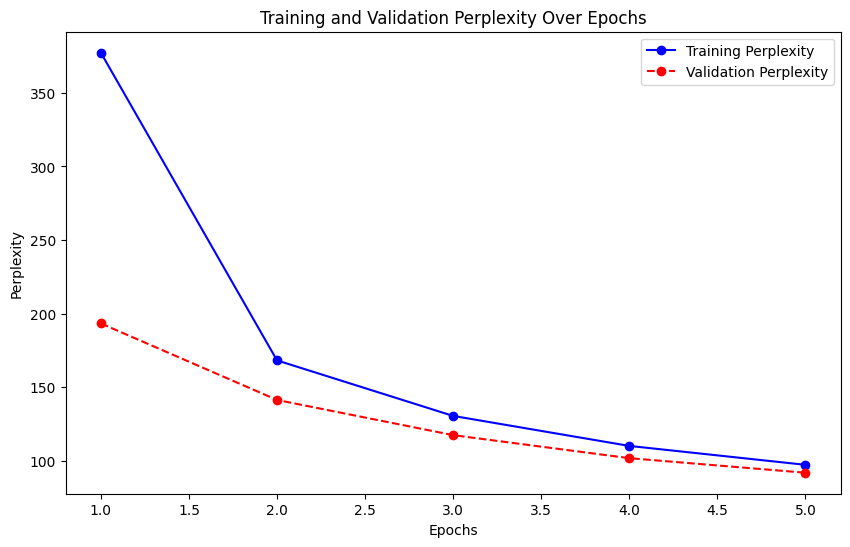

In [10]:
epochs = range(1, len(perp_vis_t) + 1)  # Assuming each entry corresponds to an epoch

plt.figure(figsize=(10, 6))
plt.plot(epochs, perp_vis_t, marker='o', linestyle='-', color='blue', label='Training Perplexity')
plt.plot(epochs, perp_vis_val, marker='o', linestyle='--', color='red', label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity Over Epochs')
plt.legend()
plt.savefig('perplexity_plot.png')
# plt.show()

In [11]:
# Save the entire model
# torch.save(model, 'model/model_LM2.pth')